In [1]:
import pandas as pd
import cca_mixture
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
from mpl_toolkits.mplot3d import Axes3D
import bayesian_nn_autoencoder as bae

## Helper methods

In [2]:
def reduce_connectome(connectome):
    n_subjects = connectome.shape[0]
    group_ICA_dim = int(np.sqrt(connectome.shape[1]))
    reduced_connectome = np.zeros((n_subjects,group_ICA_dim*(group_ICA_dim-1)/2))
    upper_tri_indices = np.triu_indices(group_ICA_dim,k=1)
    for i in range(n_subjects):
        subject = np.reshape(connectome[i,:],(group_ICA_dim,group_ICA_dim))
        reduced_connectome[i,:] = subject[upper_tri_indices]
    return reduced_connectome

In [3]:
def get_treatment_nontreatment_groups(data):
    nontreatment = data[data['TreatmentGroup'] == 'Sham Exc+Sham cognitive']
    nontreatment_index = nontreatment.index.values
    
    treatment = data[data['TreatmentGroup'] != 'Sham Exc+Sham cognitive']
    treatment_index = treatment.index.values
    
    treatment_class = pd.get_dummies(data['TreatmentGroup'])
    
    return nontreatment_index, treatment_index, treatment_class

In [4]:
def plot_study_result(X,Y):
    zero_class = np.where(Y[:, 0])
    one_class = np.where(Y[:, 1])
    two_class = np.where(Y[:, 2])
    three_class = np.where(Y[:, 3])
    
    plt.scatter(X[:, 0], X[:, 1], s=40, c='gray')
    one= plt.scatter(X[zero_class, 0], X[zero_class, 1], s=160, edgecolors='b',
                   facecolors='none', linewidths=2, label='Class C+R_Sham')
    two = plt.scatter(X[one_class, 0], X[one_class, 1], s=80, edgecolors='orange',
                   facecolors='none', linewidths=2, label='Class R+C')
    three =plt.scatter(X[two_class, 0], X[two_class, 1], s=160, edgecolors='red',
                   facecolors='none', linewidths=2, label='Class R+C_Sham')
    four = plt.scatter(X[three_class, 0], X[three_class, 1], s=80, edgecolors='green',
                   facecolors='none', linewidths=2, label='Class Double Shammy')
    plt.legend(handles=[one,two,three,four])

In [5]:
def plot_study_result_3D(X,Y,figsize = (15,15)):
    zero_class = np.where(Y[:, 0])
    one_class = np.where(Y[:, 1])
    two_class = np.where(Y[:, 2])
    three_class = np.where(Y[:, 3])
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    one= ax.scatter(X[zero_class, 0], X[zero_class, 1], X[zero_class, 2],s=160, color='b',
                     label='Class C+R_Sham')
    two = ax.scatter(X[one_class, 0], X[one_class, 1],X[one_class, 2], s=80, color='orange',
                    label='Class R+C')
    three =ax.scatter(X[two_class, 0], X[two_class, 1],X[two_class, 2], s=160, color='red',
                    label='Class R+C_Sham')
    four = ax.scatter(X[three_class, 0], X[three_class, 1],X[three_class, 2], s=80, color='green',
                     label='Class Double Shammy')
    plt.legend(handles=[one,two,three,four])

In [6]:
def separate_treatment_class(data,treatment_class):
    
    R_C_Sham = data[treatment_class['Resistance training+ Sham cognitive'] == 1]
    C_R_Sham = data[treatment_class['Cognitive training+Sham exc'] == 1]
    C_R = data[treatment_class['Resistance training + Cognitive training'] == 1]
    double_sham = data[treatment_class['Sham Exc+Sham cognitive'] == 1]
    
    return R_C_Sham,C_R_Sham,C_R,double_sham

# BL Data

In [7]:
BL_data = pd.read_excel('/home/hngu4068/Documents/SMART_STUDY/SMART_MasterDatabase_CCA.xlsx',sheetname = 1)
BL_data.head()

,TreatmentGroup,ParticipantStudyID,Ageyears,EducationYrs,TICSMScore_BL,TotalDrinksperweek_BL,TotalInformantBayerIADLscore_BL,ParticipantSubjectiveMemoryConcernTotalScore_BL,MMSETrial1UncorrectedScore_BL,MMSETrial1CorrectedScore_BL,...,rh_rostralmiddlefrontal_thickness,rh_superiorfrontal_thickness,rh_superiorparietal_thickness,rh_superiortemporal_thickness,rh_supramarginal_thickness,rh_frontalpole_thickness,rh_temporalpole_thickness,rh_transversetemporal_thickness,rh_insula_thickness,rh_MeanThickness_thickness
0,Sham Exc+Sham cognitive,2,70.59,19,21,0.000,1.160,2,28,30,...,2.195,2.565,1.961,2.491,2.238,2.276,3.588,1.884,2.836,2.27532
1,Resistance training+ Sham cognitive,3,65.62,19,27,7.000,1.231,5,27,27,...,2.297,2.570,1.981,2.609,2.259,2.496,3.097,2.132,2.634,2.31103
2,Cognitive training+Sham exc,4,78.96,14,16,0.000,1.217,3,29,30,...,2.085,2.456,2.070,2.472,2.180,2.216,3.462,2.499,2.650,2.22049
3,Resistance training + Cognitive training,6,65.70,14,24,7.000,1.269,3,28,28,...,2.335,2.689,2.170,2.645,2.461,2.818,3.097,2.495,2.748,2.39028
4,Resistance training+ Sham cognitive,7,70.92,20,24,0.000,2.680,4,27,27,...,2.438,2.594,2.305,2.688,2.458,2.484,3.384,2.452,2.743,2.48118


In [8]:
BL_treatment_no =np.zeros((BL_data.shape[0],1))
i = 0
for ele in BL_data['TreatmentGroup'].unique():
    double_sham = BL_data[BL_data['TreatmentGroup'] == ele]
    double_sham_index = double_sham.index.values
    BL_treatment_no[double_sham_index] = i
    i+=1

In [9]:
cog_headings = BL_data.columns.values
cog_headings = cog_headings[4:]
BL_neuro_scores = BL_data[cog_headings]
BL_neuro_scores = BL_neuro_scores.fillna(0)
BL_neuro_scores= BL_neuro_scores.replace('.', 0, regex=True)
BL_neuro_scores['TotalDrinksperweek_BL'] = pd.to_numeric(BL_neuro_scores['TotalDrinksperweek_BL'])
BL_neuro_scores.head()

,TICSMScore_BL,TotalDrinksperweek_BL,TotalInformantBayerIADLscore_BL,ParticipantSubjectiveMemoryConcernTotalScore_BL,MMSETrial1UncorrectedScore_BL,MMSETrial1CorrectedScore_BL,CDRSum_BL,SUMofmemorytrials_BL,ADASCOGTotalScore_BL,TrailmakingtestPartAtotaltimesec_BL,...,rh_rostralmiddlefrontal_thickness,rh_superiorfrontal_thickness,rh_superiorparietal_thickness,rh_superiortemporal_thickness,rh_supramarginal_thickness,rh_frontalpole_thickness,rh_temporalpole_thickness,rh_transversetemporal_thickness,rh_insula_thickness,rh_MeanThickness_thickness
0,21,0,1.160,2,28,30,0.0,22,10.6,37,...,2.195,2.565,1.961,2.491,2.238,2.276,3.588,1.884,2.836,2.27532
1,27,0,1.231,5,27,27,1.0,22,10.9,27,...,2.297,2.570,1.981,2.609,2.259,2.496,3.097,2.132,2.634,2.31103
2,16,0,1.217,3,29,30,0.5,13,11.9,43,...,2.085,2.456,2.070,2.472,2.180,2.216,3.462,2.499,2.650,2.22049
3,24,0,1.269,3,28,28,0.5,27,4.3,27,...,2.335,2.689,2.170,2.645,2.461,2.818,3.097,2.495,2.748,2.39028
4,24,0,2.680,4,27,27,0.5,20,12.9,26,...,2.438,2.594,2.305,2.688,2.458,2.484,3.384,2.452,2.743,2.48118


In [10]:
BL_connectome = np.loadtxt('/home/hngu4068/Documents/SMART_STUDY/NET_BL.txt')

In [11]:
#scale our data
BL_neuro_scores_scale = normalize(BL_neuro_scores)
reduced_BL_connectome = reduce_connectome(BL_connectome)
BL_connectome_normalize = normalize(reduced_BL_connectome)

# do a pca reduction
from sklearn.decomposition import PCA
pca = PCA(n_components = 20)
BL_connectome_normalize = pca.fit_transform(BL_connectome_normalize)
BL_neuro_scores_scale = pca.fit_transform(BL_neuro_scores_scale)


In [12]:
cca = cca_mixture.CCA_Mixture(BL_neuro_scores_scale,BL_connectome_normalize,n_mixtures = 4,n_epochs=7000,
                              starter_learning_rate=0.2,learning_rate_decay=0.9,learning_rate_step_decrease = 100,print_step =500)
cca.train()
BL_latent = cca.transform()

loss is -288.21
loss is -613.71
loss is -327.48
loss is -423.70
loss is -305.11
loss is -260.34
loss is -251.42
loss is -294.73
loss is -234.05
loss is -261.17
loss is -298.72
loss is -220.09
loss is -264.87
loss is -287.78


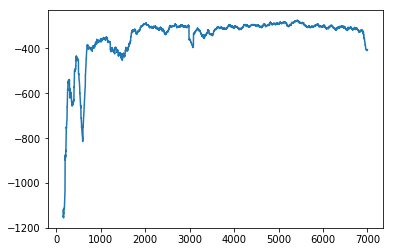

In [13]:
n_epoch = cca.n_epochs
moving_avg = np.zeros(n_epoch-150)
for i  in range(n_epoch-150):
    moving_avg[i] = np.mean(cca.avg_loss_array[i:i+100])
plt.plot(range(150,n_epoch),moving_avg)

We can see the negative log loss increasing, hopefully meaning our model is learning something

In [14]:
BL_nontreatment_index, BL_treatment_index, BL_treatment_class = get_treatment_nontreatment_groups(BL_data)
BL_treatment_study_latent = BL_latent[BL_treatment_index,:]
BL_nontreatment_study_latent = BL_latent[BL_nontreatment_index,:]

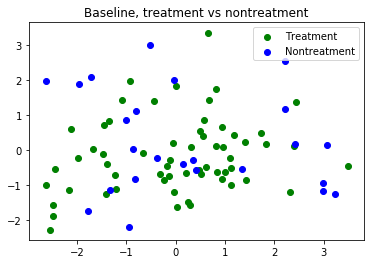

In [15]:
one = plt.scatter(BL_treatment_study_latent[:,0],BL_treatment_study_latent[:,1],color = 'green',label='Treatment')
two = plt.scatter(BL_nontreatment_study_latent[:,0],BL_nontreatment_study_latent[:,1],color = 'blue',label='Nontreatment')
plt.title('Baseline, treatment vs nontreatment')
plt.legend()

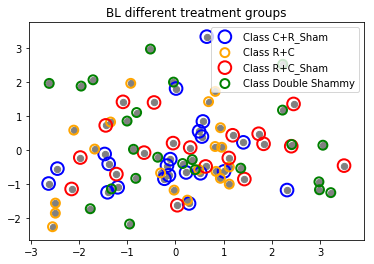

In [16]:
BL_treatment_class = pd.get_dummies(BL_data['TreatmentGroup'])
plot_study_result(BL_latent,BL_treatment_class.values)
plt.title('BL different treatment groups')

In [17]:
BL_latent_sigma = cca.transform_sigma()

We can seee that there is no real differences between each of the treatment groups. This is expected as this is baseline; i.e nooone has undergone treatment

In [18]:
BL_mean_R_C_Sham, BL_mean_C_R_Sham, BL_mean_C_R,BL_mean_double_sham = separate_treatment_class(BL_latent,BL_treatment_class)
BL_sigma_R_C_Sham, BL_sigma_C_R_Sham, BL_sigma_C_R,BL_sigma_double_sham = separate_treatment_class(BL_latent_sigma,BL_treatment_class)

In [19]:
# get the group means of each treatment group
BL_group_mean = np.zeros((4,2))
BL_group_mean[0,:] = np.mean(BL_mean_R_C_Sham)
BL_group_mean[1,:] = np.mean(BL_mean_C_R_Sham)
BL_group_mean[2,:] = np.mean(BL_mean_C_R)
BL_group_mean[3,:] = np.mean(BL_mean_double_sham)

In [20]:
# get the group means of each treatment group
BL_group_var = np.zeros((4,2,2))
BL_group_var[0] = np.mean(BL_sigma_R_C_Sham,axis = 0)
BL_group_var[1] = np.mean(BL_sigma_C_R_Sham,axis = 0)
BL_group_var[2] = np.mean(BL_sigma_C_R,axis = 0)
BL_group_var[3] = np.mean(BL_sigma_double_sham,axis = 0)

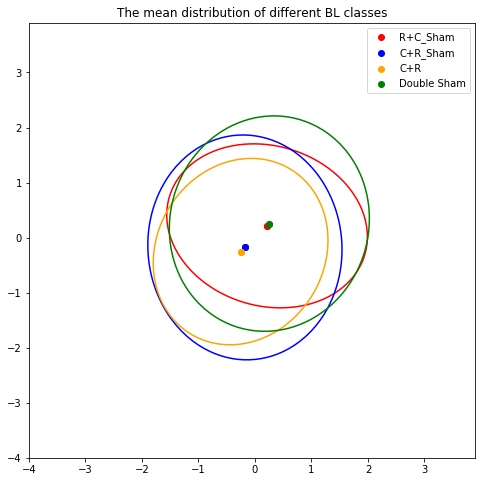

In [21]:
from scipy.stats import multivariate_normal
x, y = np.mgrid[-4:4:.1, -4:4:.1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y

fig = plt.figure(figsize=(8, 8)) 
n_lines = 1
rv = multivariate_normal(BL_group_mean[0],BL_group_var[0])
plt.scatter(BL_group_mean[0,:],BL_group_mean[0,:],c = 'red',label='R+C_Sham')
plt.contour(x, y, rv.pdf(pos),n_lines,colors = 'red')

rv = multivariate_normal(BL_group_mean[1],BL_group_var[1])
plt.scatter(BL_group_mean[1,:],BL_group_mean[1,:],c = 'blue',label='C+R_Sham')
plt.contour(x, y, rv.pdf(pos),n_lines,colors = 'blue')

rv = multivariate_normal(BL_group_mean[2],BL_group_var[2])
plt.scatter(BL_group_mean[2,:],BL_group_mean[2,:],c = 'orange',label='C+R')
plt.contour(x, y, rv.pdf(pos),1,colors = 'orange')

rv = multivariate_normal(BL_group_mean[3],BL_group_var[3])
plt.scatter(BL_group_mean[3,:],BL_group_mean[3,:],c = 'green',label='Double Sham')
plt.contour(x, y, rv.pdf(pos),n_lines,colors = 'green')

plt.legend()
plt.title('The mean distribution of different BL classes')

We plot the mean of each group of each patient's latent distribution. Each of these distributions overlap suggesting that there is no real differences between the groups as expected as baseline. 

#### Use the neural network instead

log p(x) >= -461.282
log p(x) >= -220461.281
log p(x) >= -80038.570
log p(x) >= -47768.773
log p(x) >= -33881.332
log p(x) >= -26377.229
log p(x) >= -21683.244
log p(x) >= -18599.078


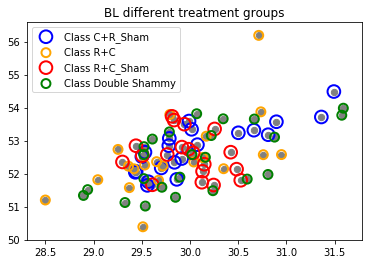

In [22]:
model = bae.bayesian_autoencoder(BL_neuro_scores_scale,BL_connectome_normalize,latent_dim = 2,regulariser_type = None,
                        n_epoch= 800,n_hidden = 800,disp = 100)
model.train()
BL_latent = model.transform(BL_connectome_normalize,BL_neuro_scores_scale)
plot_study_result(BL_latent,BL_treatment_class.values)
plt.title('BL different treatment groups')

In [23]:
BL_latent_sigma = model.transform_sigma(BL_neuro_scores_scale,BL_connectome_normalize)
BL_mean_R_C_Sham, BL_mean_C_R_Sham, BL_mean_C_R,BL_mean_double_sham = separate_treatment_class(BL_latent,BL_treatment_class)
BL_sigma_R_C_Sham, BL_sigma_C_R_Sham, BL_sigma_C_R,BL_sigma_double_sham = separate_treatment_class(BL_latent_sigma,BL_treatment_class)

In [24]:
# get the group means of each treatment group
BL_group_mean = np.zeros((4,2))
BL_group_mean[0,:] = np.mean(BL_mean_R_C_Sham)
BL_group_mean[1,:] = np.mean(BL_mean_C_R_Sham)
BL_group_mean[2,:] = np.mean(BL_mean_C_R)
BL_group_mean[3,:] = np.mean(BL_mean_double_sham)

# get the group means of each treatment group
BL_group_var = np.zeros((4,2,2))
BL_group_var[0] = np.mean(BL_sigma_R_C_Sham,axis = 0)
BL_group_var[1] = np.mean(BL_sigma_C_R_Sham,axis = 0)
BL_group_var[2] = np.mean(BL_sigma_C_R,axis = 0)
BL_group_var[3] = np.mean(BL_sigma_double_sham,axis = 0)

In [25]:
from scipy.stats import multivariate_normal
x, y = np.mgrid[-4:4:.1, -4:4:.1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y

fig = plt.figure(figsize=(8, 8)) 
n_lines = 1
rv = multivariate_normal(BL_group_mean[0],BL_group_var[0])
plt.scatter(BL_group_mean[0,:],BL_group_mean[0,:],c = 'red',label='R+C_Sham')
plt.contour(x, y, rv.pdf(pos),n_lines,colors = 'red')

rv = multivariate_normal(BL_group_mean[1],BL_group_var[1])
plt.scatter(BL_group_mean[1,:],BL_group_mean[1,:],c = 'blue',label='C+R_Sham')
plt.contour(x, y, rv.pdf(pos),n_lines,colors = 'blue')

rv = multivariate_normal(BL_group_mean[2],BL_group_var[2])
plt.scatter(BL_group_mean[2,:],BL_group_mean[2,:],c = 'orange',label='C+R')
plt.contour(x, y, rv.pdf(pos),1,colors = 'orange')

rv = multivariate_normal(BL_group_mean[3],BL_group_var[3])
plt.scatter(BL_group_mean[3,:],BL_group_mean[3,:],c = 'green',label='Double Sham')
plt.contour(x, y, rv.pdf(pos),n_lines,colors = 'green')

plt.legend()
plt.title('The mean distribution of different BL classes')

ValueError: the input matrix must be positive semidefinite

log p(x) >= -363859.156
log p(x) >= -3382.756
log p(x) >= -3391.790
log p(x) >= -3385.862
log p(x) >= -3386.198
log p(x) >= -3383.648
log p(x) >= -3391.248
log p(x) >= -3391.393


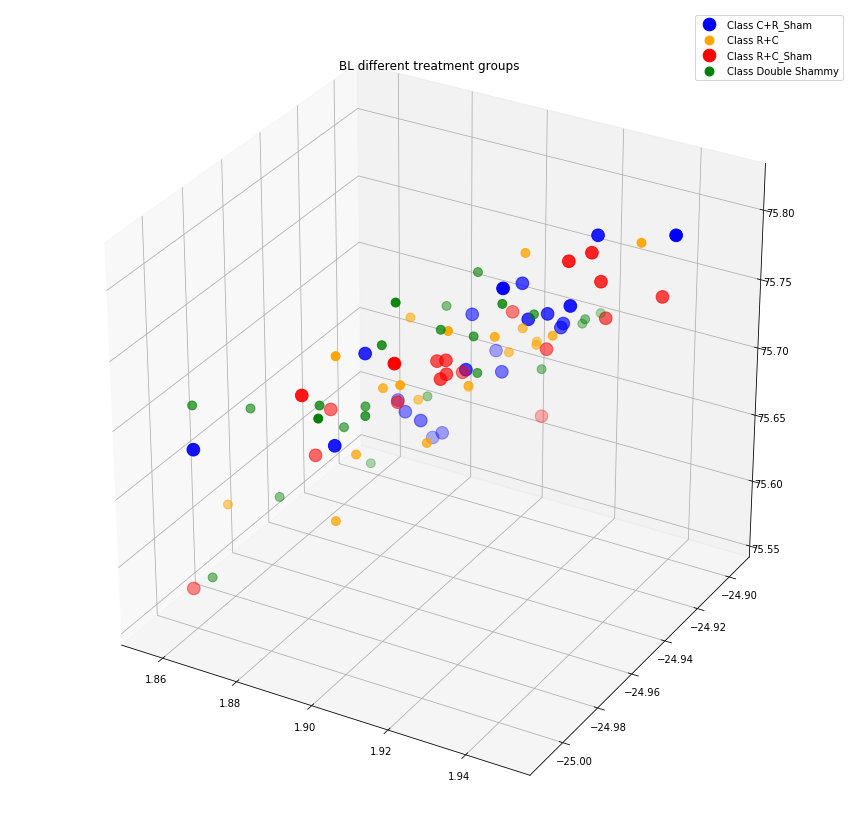

In [26]:
model = bae.bayesian_autoencoder(BL_neuro_scores_scale,BL_connectome_normalize,latent_dim = 3,regulariser_type = None,
                        n_epoch= 800,n_hidden = 800,disp = 100)
model.train()
BL_latent = model.transform(BL_neuro_scores_scale,BL_connectome_normalize)
plot_study_result_3D(BL_latent,BL_treatment_class.values)
plt.title('BL different treatment groups')

## FU1

In [22]:
FU1_data = pd.read_excel('/home/hngu4068/Documents/SMART_STUDY/SMART_MasterDatabase_CCA.xlsx',sheetname = 2)
FU1_data.head()

,TreatmentGroup,ParticipantStudyID,Ageyears,EducationYrs,TotalInformantBayerIADLscore_612,ParticipantSubjectiveMemoryConcernTotalScore_612,CDRSum_612,SUMofmemorytrials_612,ADASCOGTotalScore_612,MMSEUncorrectedScore_612,...,rh_rostralmiddlefrontal_thickness,rh_superiorfrontal_thickness,rh_superiorparietal_thickness,rh_superiortemporal_thickness,rh_supramarginal_thickness,rh_frontalpole_thickness,rh_temporalpole_thickness,rh_transversetemporal_thickness,rh_insula_thickness,rh_MeanThickness_thickness
0,Sham Exc+Sham cognitive,2,70.59,19,1.115,.,2.0,17.0,12.0,.,...,2.197,2.599,1.944,2.459,2.219,2.262,3.581,1.883,2.790,2.27350
1,Resistance training+ Sham cognitive,3,65.62,19,1.153,.,0.5,23.0,6.6,.,...,2.341,2.607,2.002,2.680,2.302,2.655,3.291,2.285,2.738,2.36391
2,Cognitive training+Sham exc,4,78.96,14,1.000,.,4.5,15.0,15.3,.,...,2.357,2.546,2.008,2.671,2.374,2.507,3.827,2.376,2.887,2.37256
3,Resistance training + Cognitive training,6,65.70,14,1.346,.,0.0,24.0,6.0,.,...,2.205,2.503,2.193,2.642,2.519,2.320,3.375,2.449,2.868,2.33653
4,Resistance training+ Sham cognitive,7,70.92,20,3.615,.,0.0,24.0,6.6,.,...,2.250,2.765,2.202,2.619,2.484,2.509,3.248,2.189,2.680,2.42852


In [23]:
nontreatment_group = FU1_data[FU1_data['TreatmentGroup'] == 'Sham Exc+Sham cognitive']
nontreatment_group_index = nontreatment_group.index.values

treatment_group = FU1_data[FU1_data['TreatmentGroup'] != 'Sham Exc+Sham cognitive']
treatment_group_index = treatment_group.index.values

FU1_treatment_class = pd.get_dummies(FU1_data['TreatmentGroup'])

In [24]:
FU1_cog_headings = FU1_data.columns.values
FU1_cog_headings = FU1_cog_headings[4:]
FU1_neuro_scores = FU1_data[FU1_cog_headings]
FU1_neuro_scores = FU1_neuro_scores.fillna(0)
FU1_neuro_scores= FU1_neuro_scores.replace('.', 0, regex=True)
FU1_neuro_scores.head()

,TotalInformantBayerIADLscore_612,ParticipantSubjectiveMemoryConcernTotalScore_612,CDRSum_612,SUMofmemorytrials_612,ADASCOGTotalScore_612,MMSEUncorrectedScore_612,TrailmakingtestPartAtotaltimesec_612,TrailmakingtestPartBtotaltimesec_612,WAISMatricesTotalScore_612,WAISSimilaritiesTotalScore_612,...,rh_rostralmiddlefrontal_thickness,rh_superiorfrontal_thickness,rh_superiorparietal_thickness,rh_superiortemporal_thickness,rh_supramarginal_thickness,rh_frontalpole_thickness,rh_temporalpole_thickness,rh_transversetemporal_thickness,rh_insula_thickness,rh_MeanThickness_thickness
0,1.115,0,2.0,17.0,12.0,0,39,0,7,16,...,2.197,2.599,1.944,2.459,2.219,2.262,3.581,1.883,2.790,2.27350
1,1.153,0,0.5,23.0,6.6,0,37,0,19,30,...,2.341,2.607,2.002,2.680,2.302,2.655,3.291,2.285,2.738,2.36391
2,1.000,0,4.5,15.0,15.3,0,48,0,5,11,...,2.357,2.546,2.008,2.671,2.374,2.507,3.827,2.376,2.887,2.37256
3,1.346,0,0.0,24.0,6.0,0,33,0,22,24,...,2.205,2.503,2.193,2.642,2.519,2.320,3.375,2.449,2.868,2.33653
4,3.615,0,0.0,24.0,6.6,0,39,0,17,25,...,2.250,2.765,2.202,2.619,2.484,2.509,3.248,2.189,2.680,2.42852


In [25]:
FU1_neuro_scores = FU1_neuro_scores.as_matrix()
FU1_neuro_treatment = minmax_scale(FU1_neuro_scores[treatment_group_index,:])
FU1_neuro_nontreatment = minmax_scale(FU1_neuro_scores[nontreatment_group_index,:])

In [26]:
pca = PCA(n_components = 15)
FU1_neuro_treatment = pca.fit_transform(FU1_neuro_treatment)

In [27]:
FU1_connectome = np.loadtxt('/home/hngu4068/Documents/SMART_STUDY/NET_FU1.txt')
FU1_connectome_reduced = reduce_connectome(FU1_connectome)

FU1_connectome_treatment = normalize(FU1_connectome_reduced[treatment_group_index,:])
FU1_connectome_nontreatment = normalize(FU1_connectome_reduced[nontreatment_group_index,:])

FU1_connectome_treatment = pca.fit_transform(FU1_connectome_treatment)
FU1_connectome_nontreatment = pca.fit_transform(FU1_connectome_nontreatment)

### Analaysis total dataset together

loss is -592.63
loss is -454.25
loss is -421.06
loss is -521.44
loss is -364.52
loss is -381.80
loss is -339.86
loss is -426.16
loss is -658.54
loss is -483.73


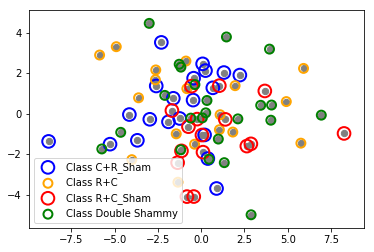

In [28]:
#do analysis all together
pca = PCA(n_components = 25)
FU1_neuro_scale = normalize(FU1_neuro_scores)
FU1_connectome_normalized = normalize(FU1_connectome_reduced)

FU1_neuro_pca = pca.fit_transform(FU1_neuro_scale)
FU1_connectome_pca = pca.fit_transform(FU1_connectome_normalized)
                                                                          
FU1_cca = cca_mixture.CCA_Mixture(FU1_neuro_pca,FU1_connectome_pca,n_mixtures = 4,n_epochs=7000,
                              starter_learning_rate=0.2,learning_rate_decay=0.6,learning_rate_step_decrease = 50,print_step =700)
FU1_cca.train()
FU1_latent = FU1_cca.transform()
plot_study_result(FU1_latent,FU1_treatment_class.values)

### Obtain the variances and plot them

In [29]:
FU1_latents_sigma = FU1_cca.transform_sigma()

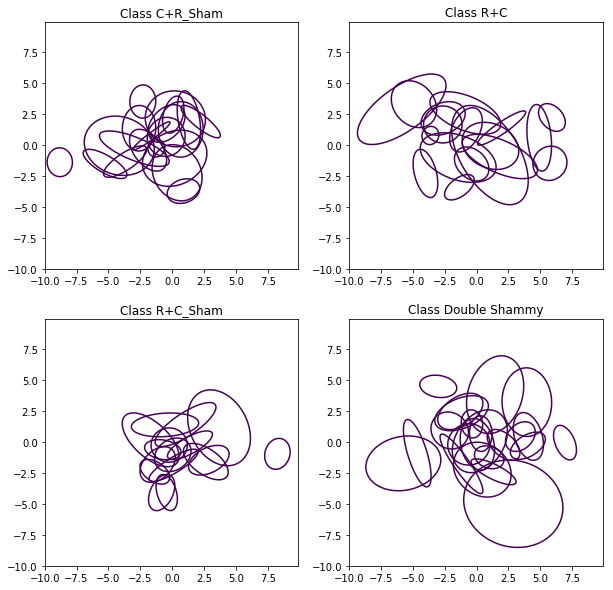

In [30]:
from scipy.stats import multivariate_normal
x, y = np.mgrid[-10:10:.1, -10:10:.1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y

fig = plt.figure(figsize=(10, 10)) 
n_lines = 1
for i in range(FU1_latent.shape[0]):
    if np.argmax(FU1_treatment_class.values[i]) == 0:
        rv = multivariate_normal(FU1_latent[i,:], FU1_latents_sigma[i,:,:])
        ax1 = plt.subplot(2,2,1)
        ax1.contour(x, y, rv.pdf(pos),n_lines,c = 'blue')
        plt.title('Class C+R_Sham')
    elif np.argmax(FU1_treatment_class.values[i]) == 1:
        rv = multivariate_normal(FU1_latent[i,:], FU1_latents_sigma[i,:,:])
        ax2 = plt.subplot(2,2,2)
        ax2.contour(x, y, rv.pdf(pos),n_lines,c = 'green')
        plt.title('Class R+C')
    elif np.argmax(FU1_treatment_class.values[i]) == 2:
        rv = multivariate_normal(FU1_latent[i,:], FU1_latents_sigma[i,:,:])
        ax3 = plt.subplot(2,2,3)
        ax3.contour(x, y, rv.pdf(pos),n_lines,c = 'red')
        plt.title('Class R+C_Sham')
    else:
        rv = multivariate_normal(FU1_latent[i,:], FU1_latents_sigma[i,:,:])
        ax4 = plt.subplot(2,2,4)
        ax4.contour(x, y, rv.pdf(pos),n_lines,c = 'purple')
        plt.title('Class Double Shammy')

### obtain the means of each treatment groups mean and variance and plot them

In [31]:
# get the mean and variances of the different treatment groups
FU1_mean_R_C_Sham, FU1_mean_C_R_Sham, FU1_mean_C_R,FU1_mean_double_sham = separate_treatment_class(FU1_latent,FU1_treatment_class)
FU1_sigma_R_C_Sham, FU1_sigma_C_R_Sham, FU1_sigma_C_R,FU1_sigma_double_sham = separate_treatment_class(FU1_latents_sigma,FU1_treatment_class)

In [32]:
# get the group means of each treatment group
FU1_group_mean = np.zeros((4,2))
FU1_group_mean[0,:] = np.mean(FU1_mean_R_C_Sham)
FU1_group_mean[1,:] = np.mean(FU1_mean_C_R_Sham)
FU1_group_mean[2,:] = np.mean(FU1_mean_C_R)
FU1_group_mean[3,:] = np.mean(FU1_mean_double_sham)

In [33]:
# get the group means of each treatment group
FU1_group_var = np.zeros((4,2,2))
FU1_group_var[0] = np.mean(FU1_sigma_R_C_Sham,axis = 0)
FU1_group_var[1] = np.mean(FU1_sigma_C_R_Sham,axis = 0)
FU1_group_var[2] = np.mean(FU1_sigma_C_R,axis = 0)
FU1_group_var[3] = np.mean(FU1_sigma_double_sham,axis = 0)

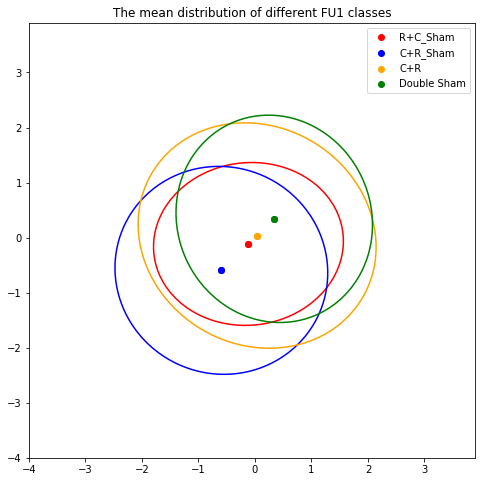

In [34]:
from scipy.stats import multivariate_normal
x, y = np.mgrid[-4:4:.1, -4:4:.1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y

fig = plt.figure(figsize=(8, 8)) 
n_lines = 1
rv = multivariate_normal(FU1_group_mean[0],FU1_group_var[0])
plt.scatter(FU1_group_mean[0,:],FU1_group_mean[0,:],c = 'red',label='R+C_Sham')
plt.contour(x, y, rv.pdf(pos),n_lines,colors = 'red')

rv = multivariate_normal(FU1_group_mean[1],FU1_group_var[1])
plt.scatter(FU1_group_mean[1,:],FU1_group_mean[1,:],c = 'blue',label='C+R_Sham')
plt.contour(x, y, rv.pdf(pos),n_lines,colors = 'blue')

rv = multivariate_normal(FU1_group_mean[2],FU1_group_var[2])
plt.scatter(FU1_group_mean[2,:],FU1_group_mean[2,:],c = 'orange',label='C+R')
plt.contour(x, y, rv.pdf(pos),1,colors = 'orange')

rv = multivariate_normal(FU1_group_mean[3],FU1_group_var[3])
plt.scatter(FU1_group_mean[3,:],FU1_group_mean[3,:],c = 'green',label='Double Sham')
plt.contour(x, y, rv.pdf(pos),n_lines,colors = 'green')

plt.legend()
plt.title('The mean distribution of different FU1 classes')

We can see that the group that did both cognitive and resistance is different from the rest of the treatment groups

#### Use a neural network

In [ ]:
model = bae.bayesian_autoencoder(FU1_neuro_scale,FU1_connectome_normalized,latent_dim = 2,regulariser_type = None,
                        n_epoch= 800,n_hidden = 1000,disp = 100,learning_rate_initial = 0.001)
model.train()
FU1_latent = model.transform(FU1_neuro_scale,FU1_connectome_normalized)
plot_study_result(FU1_latent,FU1_treatment_class.values)
plt.title('FU1 different treatment groups')

In [ ]:
FU1_latents_sigma = model.transform_sigma(FU1_neuro_scale,FU1_connectome_normalized)
FU1_mean_R_C_Sham, FU1_mean_C_R_Sham, FU1_mean_C_R,FU1_mean_double_sham = separate_treatment_class(FU1_latent,FU1_treatment_class)
FU1_sigma_R_C_Sham, FU1_sigma_C_R_Sham, FU1_sigma_C_R,FU1_sigma_double_sham = separate_treatment_class(FU1_latents_sigma,FU1_treatment_class)

In [ ]:
# get the group means of each treatment group
FU1_group_mean = np.zeros((4,2))
FU1_group_mean[0,:] = np.mean(FU1_mean_R_C_Sham)
FU1_group_mean[1,:] = np.mean(FU1_mean_C_R_Sham)
FU1_group_mean[2,:] = np.mean(FU1_mean_C_R)
FU1_group_mean[3,:] = np.mean(FU1_mean_double_sham)

# get the group means of each treatment group
FU1_group_var = np.zeros((4,2,2))
FU1_group_var[0] = np.diag(np.mean(FU1_sigma_R_C_Sham,axis = 0))
FU1_group_var[1] = np.diag(np.mean(FU1_sigma_C_R_Sham,axis = 0))
FU1_group_var[2] = np.diag(np.mean(FU1_sigma_C_R,axis = 0))
FU1_group_var[3] = np.diag(np.mean(FU1_sigma_double_sham,axis = 0))

In [ ]:
from scipy.stats import multivariate_normal
x, y = np.mgrid[-4:4:.1, -4:4:.1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y

fig = plt.figure(figsize=(8, 8)) 
n_lines = 1
rv = multivariate_normal(FU1_group_mean[0],FU1_group_var[0])
plt.scatter(FU1_group_mean[0,:],FU1_group_mean[0,:],c = 'red',label='R+C_Sham')
plt.contour(x, y, rv.pdf(pos),n_lines,colors = 'red')

rv = multivariate_normal(FU1_group_mean[1],FU1_group_var[1])
plt.scatter(FU1_group_mean[1,:],FU1_group_mean[1,:],c = 'blue',label='C+R_Sham')
plt.contour(x, y, rv.pdf(pos),n_lines,colors = 'blue')

rv = multivariate_normal(FU1_group_mean[2],FU1_group_var[2])
plt.scatter(FU1_group_mean[2,:],FU1_group_mean[2,:],c = 'orange',label='C+R')
plt.contour(x, y, rv.pdf(pos),1,colors = 'orange')

rv = multivariate_normal(FU1_group_mean[3],FU1_group_var[3])
plt.scatter(FU1_group_mean[3,:],FU1_group_mean[3,:],c = 'green',label='Double Sham')
plt.contour(x, y, rv.pdf(pos),n_lines,colors = 'green')

plt.legend()
plt.title('The mean distribution of different FU1 classes')

## Hypothesis testing

We perform a one way ANOVA on the transformed variable's means and variance. The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean.

In [35]:
stats.f_oneway(FU1_mean_R_C_Sham,FU1_mean_C_R_Sham,FU1_mean_C_R,FU1_mean_double_sham)

F_onewayResult(statistic=array([ 2.37229243,  2.03619431]), pvalue=array([ 0.07728319,  0.11626884]))

In [36]:
stats.f_oneway(FU1_sigma_R_C_Sham,FU1_sigma_C_R_Sham,FU1_sigma_C_R,FU1_sigma_double_sham)

F_onewayResult(statistic=array([[ 0.38671001,  0.27421815],
       [ 0.27421815,  1.09737401]]), pvalue=array([[ 0.76289296,  0.84380956],
       [ 0.84380956,  0.35581176]]))

We fail toreject the null that two or more groups have the same population mean and variances?

### try to do a hypothesis test for covariance
http://www.philender.com/courses/multivariate/notes3/covar.html

Hypotheses

$H_0$: population covariances are the same

$H_1$: at least one is different

In [37]:
k =4.0 #n classes
p = 3.0

n1 = FU1_mean_R_C_Sham.shape[0]
n2 = FU1_mean_C_R_Sham.shape[0]
n3 = FU1_mean_C_R.shape[0]
n4 = FU1_mean_double_sham.shape[0]

In [38]:
c1 = (1.0/(n1-1))*FU1_group_var[0]    
c2 = (1.0/(n2-1))*FU1_group_var[1]    
c3 = (1.0/(n3-1))*FU1_group_var[2] 
c4 = (1.0/(n4-1))*FU1_group_var[3] 

In [39]:
n = n1+n2+n3 + n4
c = np.sum(FU1_group_var,axis = 0)/(n-k) 

In [40]:
from numpy.linalg import det
from numpy import log

d = det(c)    
d1 = det(c1)    
d2 = det(c2)    
d3 = det(c3)
d4 = det(c4)
m = ((n-k)*log(d))-((n1-1)*log(d1) + (n2-1)*log(d2) + (n3-1)*log(d3) + (n4-1)*log(d4))

In [41]:
h=1-((2*p*p+3*p-1.0)/(6*(p+1)*(k-1))*(1.0/(n1-1)+1.0/(n2-1)+1.0/(n3-1) + 1.0/(n4-1) -1.0/(n-k)))

In [42]:
chi_val = m*h
df = p*(p+1.0)*(k-1.0)/2
from scipy.stats import chi
print chi.pdf(chi_val,df)

7.12259965867e-05


We therefore reject the null that the mean covariances are not different between population groups

### We test across time i.e. BL vs FU1

In [43]:
print stats.f_oneway(BL_mean_R_C_Sham,FU1_mean_R_C_Sham)
print stats.f_oneway(BL_sigma_R_C_Sham,FU1_sigma_R_C_Sham)

F_onewayResult(statistic=array([ 0.35166121,  6.14745211]), pvalue=array([ 0.5572168 ,  0.01844088]))
F_onewayResult(statistic=array([[ 0.00201387,  0.97100787],
       [ 0.97100787,  0.23820058]]), pvalue=array([[ 0.96447646,  0.33159908],
       [ 0.33159908,  0.62873604]]))


In [44]:
print stats.f_oneway(BL_mean_C_R_Sham,FU1_mean_C_R_Sham)
print stats.f_oneway(BL_sigma_C_R_Sham,FU1_sigma_C_R_Sham)

F_onewayResult(statistic=array([ 4.33216514,  1.06362856]), pvalue=array([ 0.04401084,  0.30874264]))
F_onewayResult(statistic=array([[ 0.40152551,  0.00096664],
       [ 0.00096664,  0.59551942]]), pvalue=array([[ 0.53000144,  0.97535569],
       [ 0.97535569,  0.44494367]]))


In [45]:
print stats.f_oneway(BL_mean_C_R,FU1_mean_C_R)
print stats.f_oneway(BL_sigma_C_R,FU1_sigma_C_R)

F_onewayResult(statistic=array([ 0.01002405,  1.68791805]), pvalue=array([ 0.92080443,  0.20213499]))
F_onewayResult(statistic=array([[ 4.49264422,  1.44636405],
       [ 1.44636405,  0.93220265]]), pvalue=array([[ 0.04100425,  0.23696275],
       [ 0.23696275,  0.34073278]]))


In [46]:
print stats.f_oneway(BL_mean_double_sham,FU1_mean_double_sham)
print stats.f_oneway(BL_sigma_double_sham,FU1_sigma_double_sham)

F_onewayResult(statistic=array([ 0.13139345,  0.0255179 ]), pvalue=array([ 0.71868855,  0.87379822]))
F_onewayResult(statistic=array([[ 0.13308691,  1.04760096],
       [ 1.04760096,  0.05137108]]), pvalue=array([[ 0.71696158,  0.31153121],
       [ 0.31153121,  0.82172089]]))


Using a one way ANOVA, we see no differences between each of the groups across time...

# Lets try using t-sne for data visualtion

In [47]:
from sklearn.manifold import TSNE

## Just use neuro scores

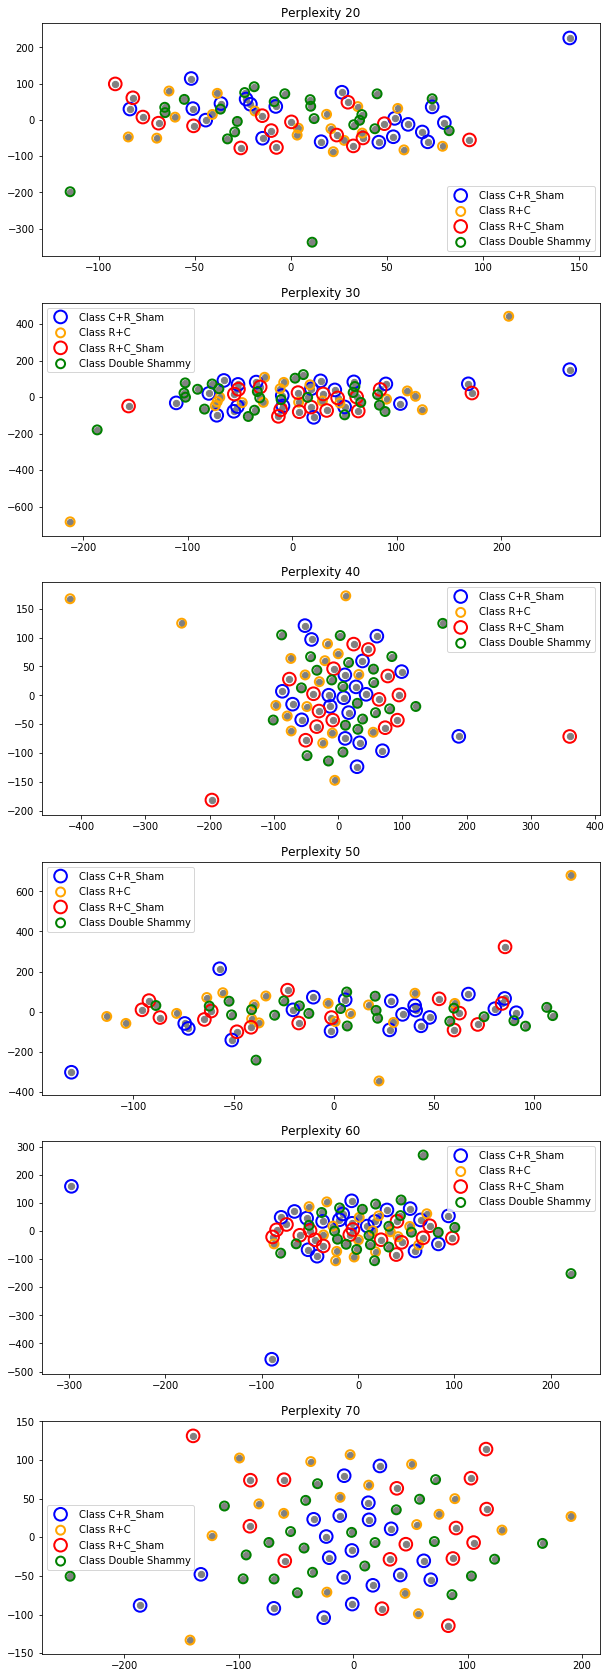

In [48]:
perplexity = [20,30,40,50,60,70]
fig = plt.figure(figsize=(10, 30)) 
for i in range(0,len(perplexity)):
    model = TSNE(n_components=2, perplexity=perplexity[i], early_exaggeration=4.0, learning_rate=1000.0, 
     n_iter=1000, n_iter_without_progress=30, min_grad_norm=1e-07, metric='euclidean', init='random', 
     verbose=0, random_state=None, method='barnes_hut', angle=0.5)
    FU1_neuro_transformed = model.fit_transform(FU1_neuro_scale)
    ax1 = plt.subplot(6,1,i+1)
    plot_study_result(FU1_neuro_transformed,FU1_treatment_class.values)
    plt.title('Perplexity ' + str(perplexity[i]))           

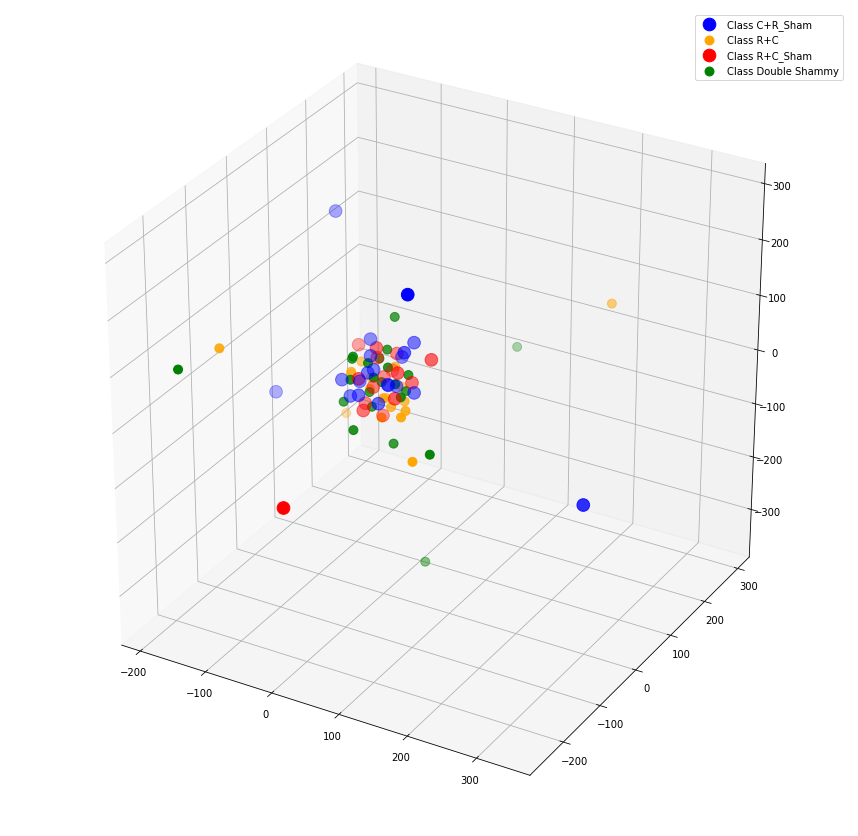

In [49]:
model = TSNE(n_components=3, perplexity=50, early_exaggeration=4.0, learning_rate=1500.0, 
 n_iter=7000, n_iter_without_progress=30, min_grad_norm=1e-07, metric='euclidean', init='random', 
 verbose=0, random_state=None, method='barnes_hut', angle=0.5)
FU1_neuro_transformed = model.fit_transform(FU1_neuro_scale)  
plot_study_result_3D(FU1_neuro_transformed,FU1_treatment_class.values)

### Use the functional data

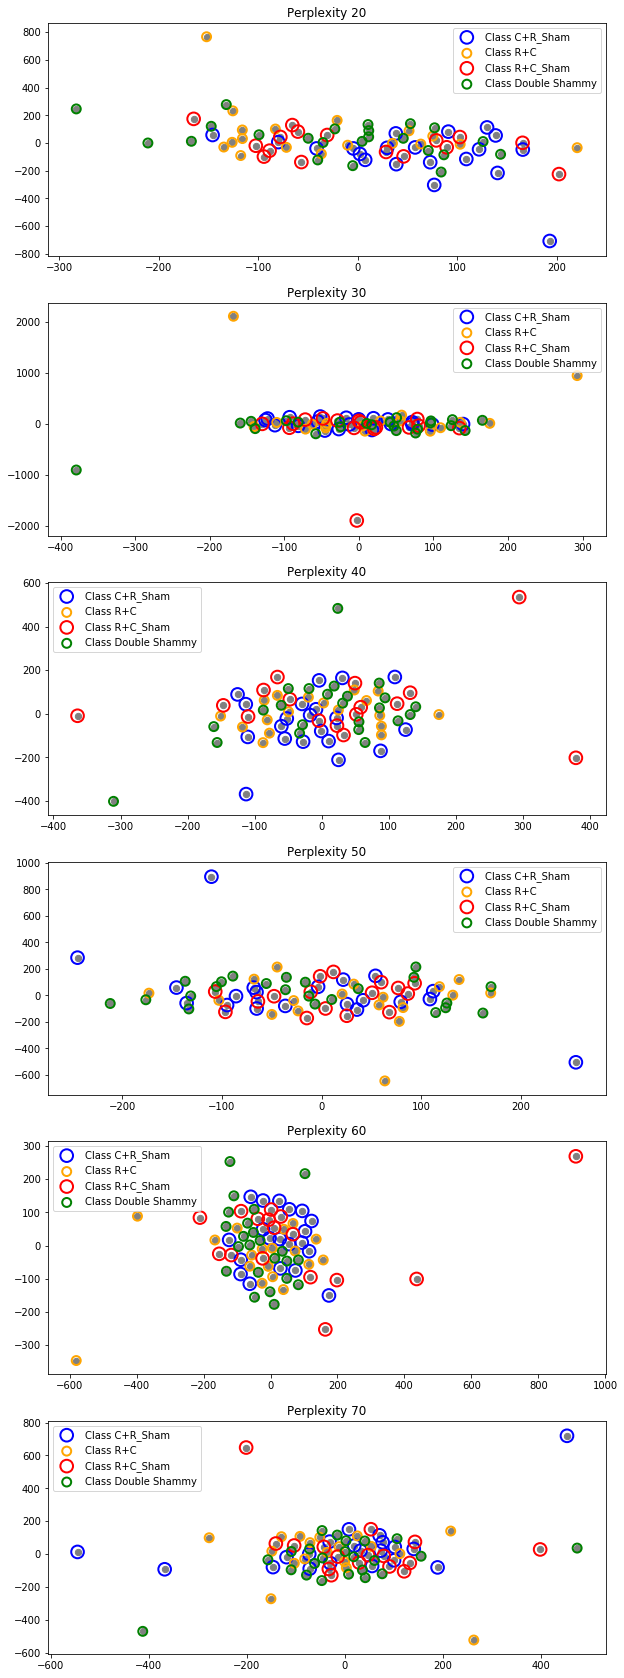

In [50]:
fig = plt.figure(figsize=(10, 30)) 
for i in range(0,len(perplexity)):
    model = TSNE(n_components=2, perplexity=perplexity[i], early_exaggeration=4.0, learning_rate=2000.0, 
     n_iter=5000, n_iter_without_progress=30, min_grad_norm=1e-07, metric='euclidean', init='random', 
     verbose=0, random_state=None, method='barnes_hut', angle=0.5)
    FU1_connectome_transformed = model.fit_transform(FU1_connectome_normalized)
    ax1 = plt.subplot(6,1,i+1)
    plot_study_result(FU1_connectome_transformed,FU1_treatment_class.values)
    plt.title('Perplexity ' + str(perplexity[i])) 

It seems like using the data separately doesn't do much in terms of clustering the data.

## Lets concatenate the data

Lets try simply concatenating the data and then applying tsne.

In [51]:
FU1_combined = normalize(np.concatenate((FU1_neuro_scores,FU1_connectome_reduced),axis = 1))

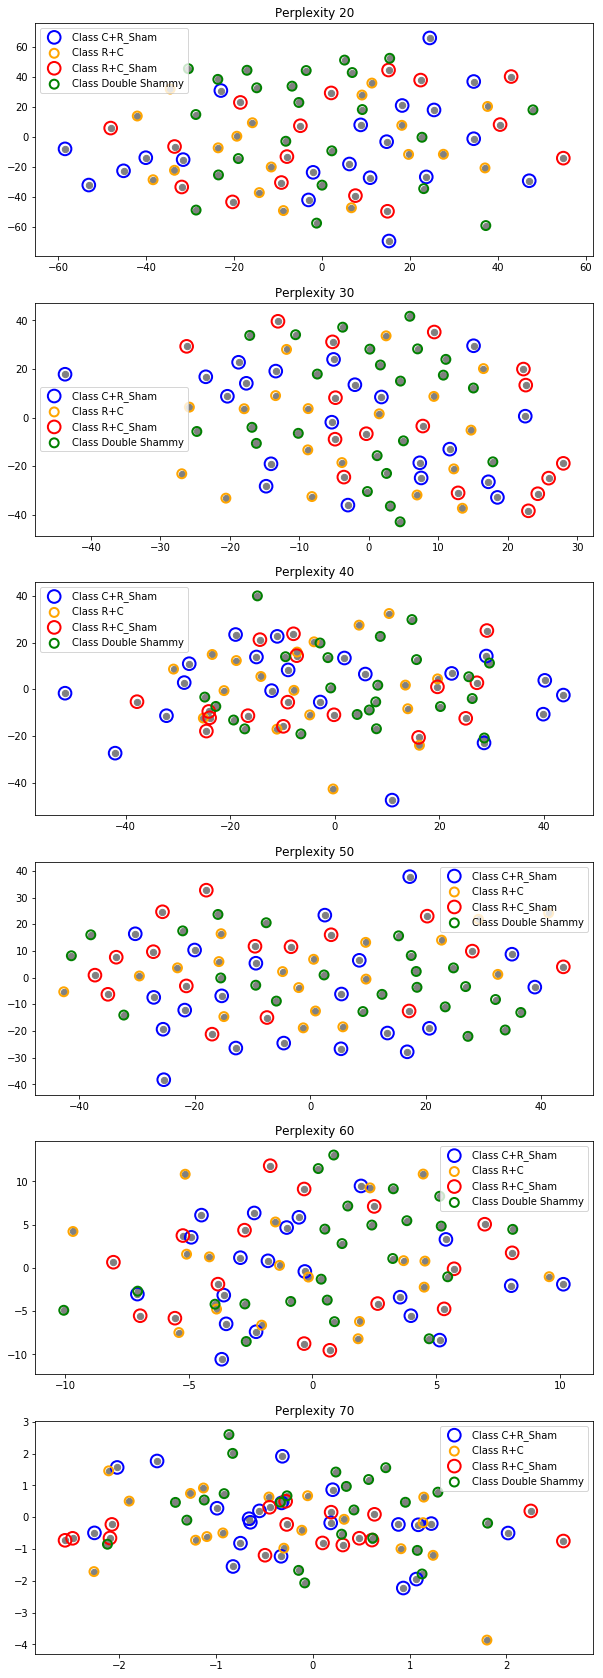

In [52]:
fig = plt.figure(figsize=(10, 30)) 
for i in range(0,len(perplexity)):
    model = TSNE(n_components=2, perplexity=perplexity[i], early_exaggeration=4.0, learning_rate=200.0, 
     n_iter=2000, n_iter_without_progress=30, min_grad_norm=1e-07, metric='euclidean', init='random', 
     verbose=0, random_state=None, method='barnes_hut', angle=0.5)
    FU1_combined_transformed = model.fit_transform(FU1_combined)
    ax1 = plt.subplot(6,1,i+1)
    plot_study_result(FU1_combined_transformed,FU1_treatment_class.values)
    plt.title('Perplexity ' + str(perplexity[i])) 

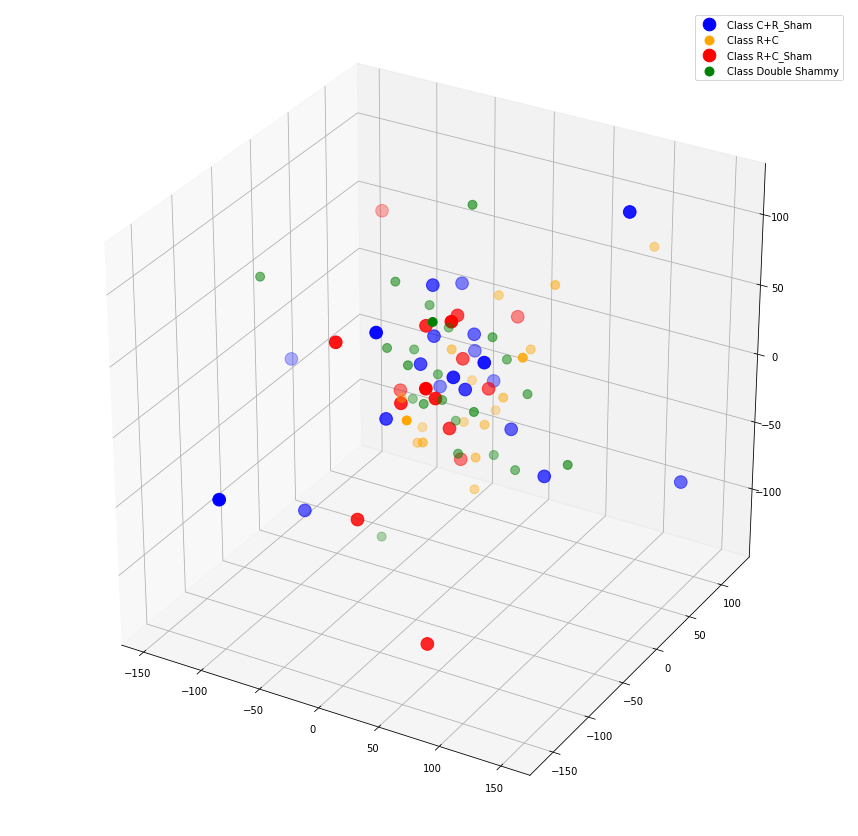

In [59]:
model = TSNE(n_components=3, perplexity=50, early_exaggeration=4.0, learning_rate=1500.0, 
 n_iter=7000, n_iter_without_progress=30, min_grad_norm=1e-07, metric='euclidean', init='random', 
 verbose=0, random_state=None, method='barnes_hut', angle=0.5)
FU1_combined_transformed = model.fit_transform(FU1_combined)  
plot_study_result_3D(FU1_combined_transformed,FU1_treatment_class.values)

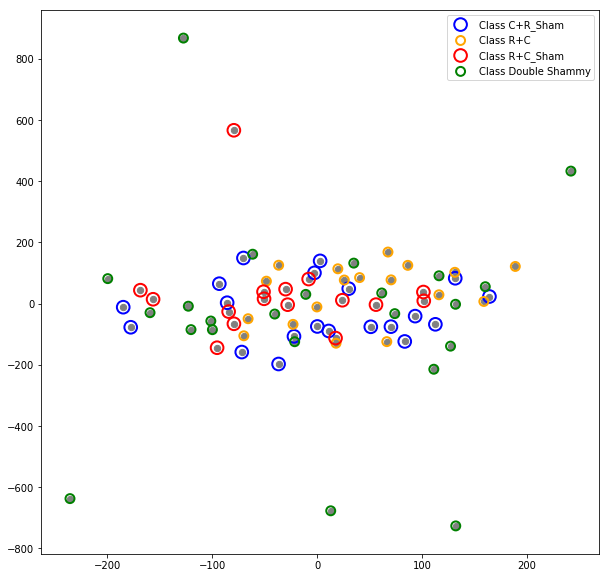

In [54]:
plt.figure(figsize = (10,10))
reduce_model = PCA(n_components = 500)
FU1_combined_reduced = reduce_model.fit_transform(FU1_combined)
model = TSNE(n_components=2, perplexity=5, early_exaggeration=4.0, learning_rate=1500.0, 
 n_iter=2000, n_iter_without_progress=30, min_grad_norm=1e-07, metric='euclidean', init='random', 
 verbose=0, random_state=None, method='barnes_hut', angle=0.5)
FU1_reduced_transformed = model.fit_transform(FU1_combined_reduced)
plot_study_result(FU1_reduced_transformed,FU1_treatment_class.values)